# Week6 Time Series 정규세션 과제

### 주가 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
### Box-Jenkins 방법론
- 식별
- 추정
- 진단
- 예측

## 라이브러리 불러오기

In [385]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults
import matplotlib as mpl

C:\Users\seriz\AppData\Local\Temp/ipykernel_38576/2883491734.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 주가 데이터 불러오기
- 예) 삼성 005930.KS

In [386]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


# 식별 

In [387]:
def stationarity_test(timeseries):
    # Augmented Dickey-Fuller Test
    adf_test = adfuller(timeseries)
    print('ADF Statistic:', adf_test[0])
    print('p-value:', adf_test[1])
    print('Critical Values:', adf_test[4])
    
    # KPSS Test
    kpss_test = kpss(timeseries)
    print('\nKPSS Statistic:', kpss_test[0])
    print('p-value:', kpss_test[1])
    print('Critical Values:', kpss_test[3])

stationarity_test(samsung_df['price'])

ADF Statistic: -0.21218947966329235
p-value: 0.9370529809409828
Critical Values: {'1%': -3.450886958636161, '5%': -2.870586350823483, '10%': -2.5715897843576827}

KPSS Statistic: 2.145211628190742
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\seriz\AppData\Local\Temp/ipykernel_38576/1628299279.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(timeseries)


p-value가 0.94 가량이므로 비정상 시계열임

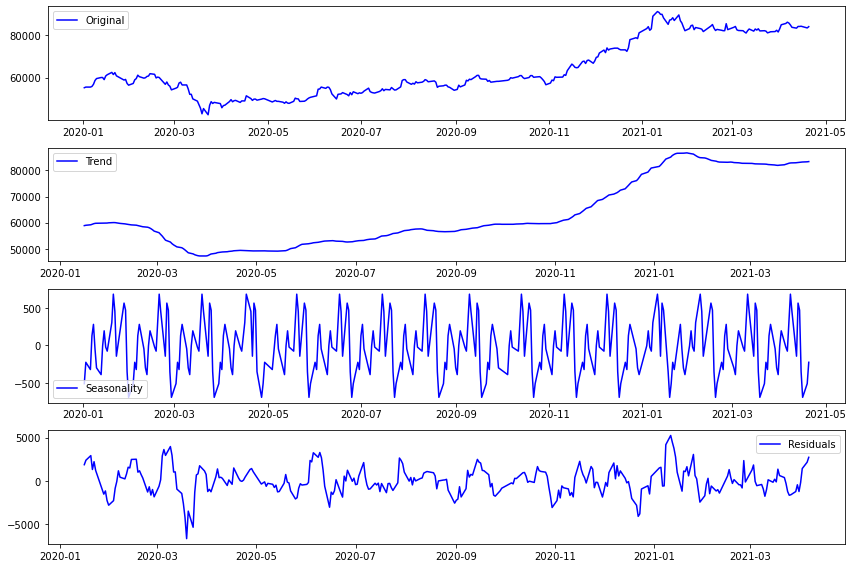

In [388]:
# 시계열 분해 및 시각화
decomposition = seasonal_decompose(samsung_df['price'], model='additive', period=20) # 주말에는 관측값이 없기 때문에 period=20
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(samsung_df, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

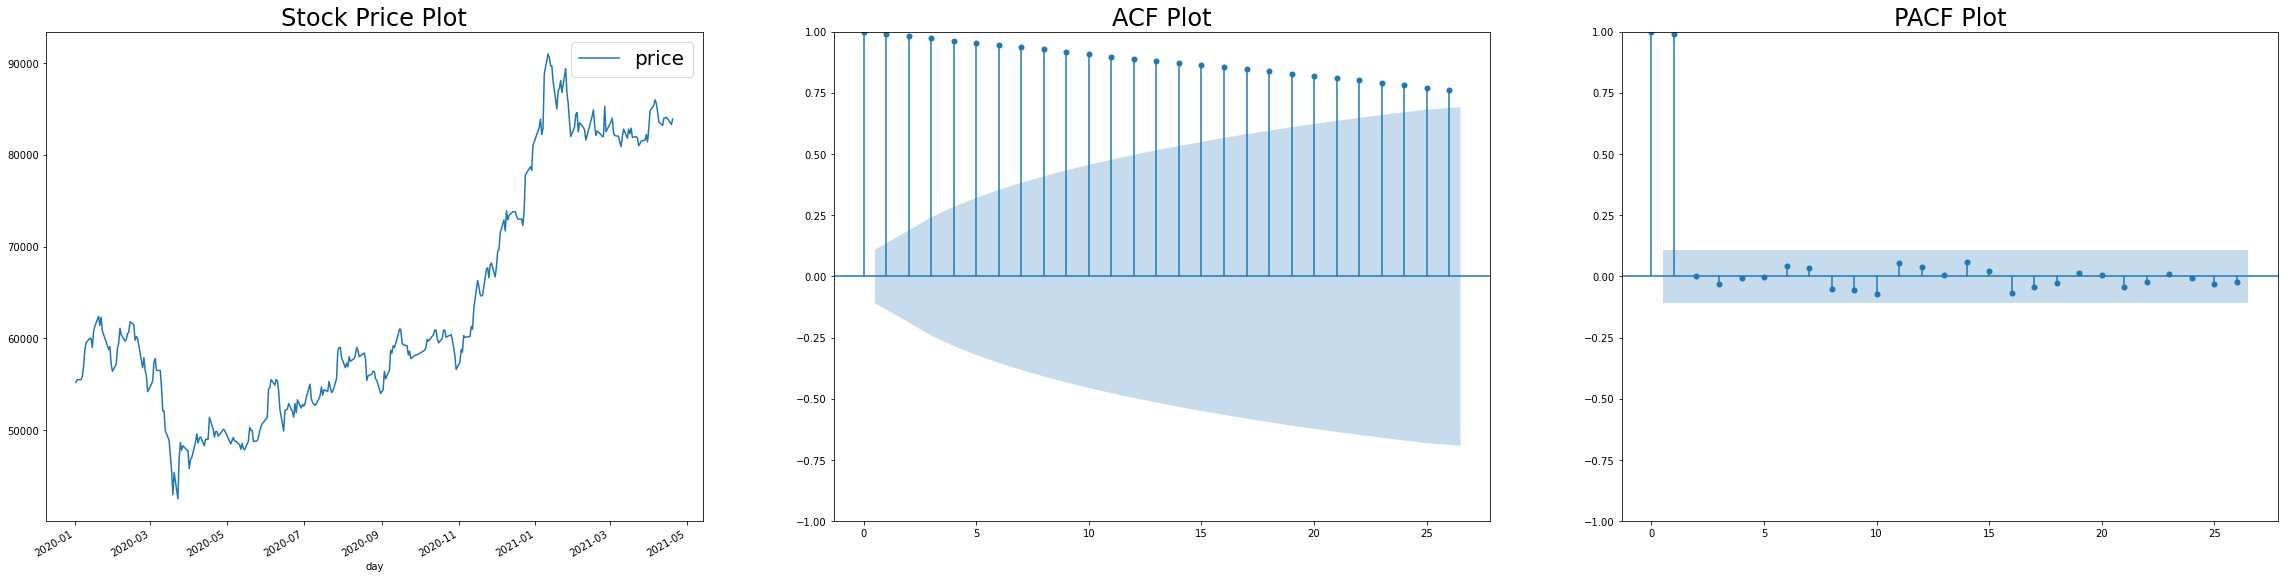

In [389]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(40, 10))
mpl.rcParams['font.size'] = 20

# 주식 가격 플롯
samsung_df.plot(ax=axs[0], linestyle='-')
axs[0].set_title('Stock Price Plot')

# ACF 플롯
plot_acf(samsung_df, ax=axs[1])
axs[1].set_title('ACF Plot')

# PACF 플롯
plot_pacf(samsung_df, ax=axs[2])
axs[2].set_title('PACF Plot')

plt.show()

현재 ACF 그래프는 지수적으로 감소하는 사인함수 형태를 띄고 있으며, PACF 그래프는 시차 1 이후부터는 0에 근사한 값으로 절단되는 형태를 띄고 있다.

이는 해당 주가 데이터가 AR 모형을 따르고 있음 방증한다.

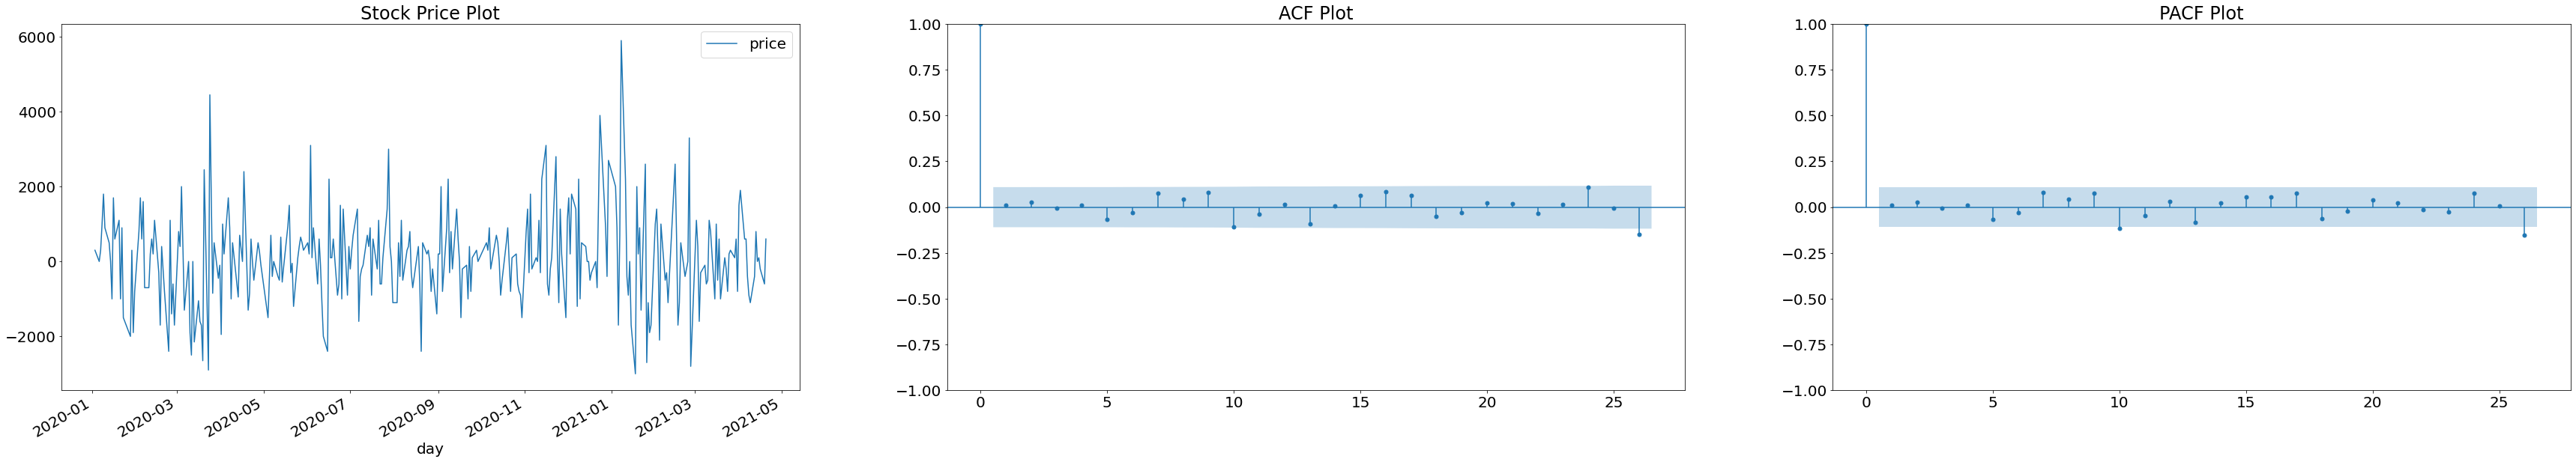

In [390]:
# 차분 및 시각화
diff = samsung_df.diff().dropna()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(60, 10))
mpl.rcParams['font.size'] = 20

# 주식 가격 플롯
diff.plot(ax=axs[0], linestyle='-')
axs[0].set_title('Stock Price Plot')

# ACF 플롯
plot_acf(diff, ax=axs[1])
axs[1].set_title('ACF Plot')

# PACF 플롯
plot_pacf(diff, ax=axs[2])
axs[2].set_title('PACF Plot')

plt.show()

In [391]:
# ARIMA 모델 식별
auto_arima_model = auto_arima(diff, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5485.054, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5477.508, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5479.407, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5479.428, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5481.036, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5477.791, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.509 seconds


시각화를 통해서도 1차 차분 이후에 주가 데이터가 ARMA(0,0)을 따른다는 사실이 시각화를 통해서도 증명됨.

In [392]:
def stationarity_test(timeseries):
    # Augmented Dickey-Fuller Test
    adf_test = adfuller(timeseries)
    print('ADF Statistic:', adf_test[0])
    print('p-value:', adf_test[1])
    print('Critical Values:', adf_test[4])
    
    # KPSS Test
    kpss_test = kpss(timeseries)
    print('\nKPSS Statistic:', kpss_test[0])
    print('p-value:', kpss_test[1])
    print('Critical Values:', kpss_test[3])

stationarity_test(diff)

ADF Statistic: -17.602795089961845
p-value: 3.913882166016894e-30
Critical Values: {'1%': -3.450951662384033, '5%': -2.8706147570800784, '10%': -2.571604931640625}

KPSS Statistic: 0.20237853484536686
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\seriz\AppData\Local\Temp/ipykernel_38576/549851141.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(timeseries)


# 추정

In [393]:
# ARIMA 모델 추정
order = auto_arima_model.order
arima_model = sm.tsa.arima.ARIMA(diff, order=auto_arima_model.order)
arima_result = arima_model.fit()

c:\Users\seriz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\seriz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\seriz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [394]:
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  321
Model:                          ARIMA   Log Likelihood               -2736.897
Date:                Tue, 27 Feb 2024   AIC                           5477.794
Time:                        22:54:26   BIC                           5485.337
Sample:                             0   HQIC                          5480.805
                                - 321                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.4090     71.177      1.256      0.209     -50.095     228.913
sigma2      1.497e+06   8.89e+04     16.831      0.000    1.32e+06    1.67e+06
Ljung-Box (L1) (Q):                   0.05   Jarque-

# 진단 

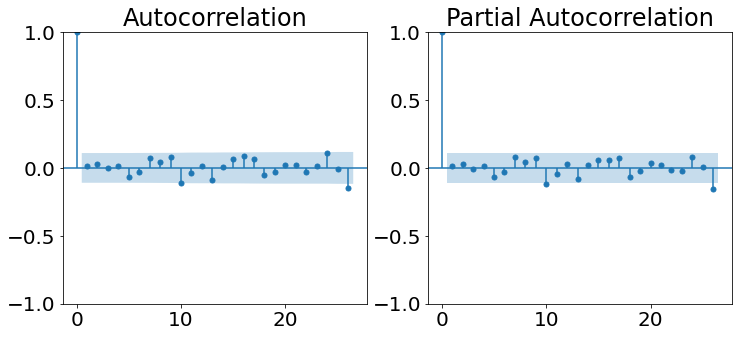

In [395]:
# ARIMA 모델 진단
residuals = arima_result.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, ax=ax[1])
plt.show()

# 예측 

In [396]:
# 모델 평가 및 예측
aic = arima_result.aic
bic = arima_result.bic
print('AIC:', aic)
print('BIC:', bic)

AIC: 5477.793785039206
BIC: 5485.336667285466


In [397]:
# 모델로부터 예측
forecast_steps = 20
forecast = arima_result.forecast(steps=forecast_steps)

c:\Users\seriz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\seriz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [398]:
# 예측 대상 일자들도 포함하고 있는 데이터 새로 생성

samsung_df_test = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-05-20',
                      progress=False)

samsung_df_test = samsung_df_test[["Close"]]

samsung_df_test = samsung_df_test.reset_index()

samsung_df_test.columns = ['day', 'price']

samsung_df_test['day'] = pd.to_datetime(samsung_df_test['day'])

samsung_df_test.index = samsung_df_test['day']
samsung_df_test.set_index('day', inplace=True)

In [399]:
forecast

321    89.409027
322    89.409027
323    89.409027
324    89.409027
325    89.409027
326    89.409027
327    89.409027
328    89.409027
329    89.409027
330    89.409027
331    89.409027
332    89.409027
333    89.409027
334    89.409027
335    89.409027
336    89.409027
337    89.409027
338    89.409027
339    89.409027
340    89.409027
Name: predicted_mean, dtype: float64

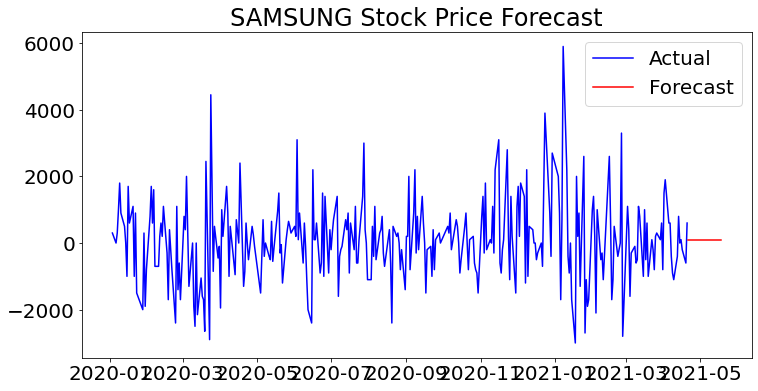

In [400]:
# 예측 시각화
forecast_index = pd.date_range(start=samsung_df.index[-1], periods=forecast_steps + 1, closed='right', freq='B')
forecast_series = pd.Series(forecast.values, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(diff, label='Actual', color='blue')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('SAMSUNG Stock Price Forecast')
plt.legend()
plt.show()

제대로 예측이 되지 않는 모습을 보임